## Regression Analysis_State-wise_Missouri

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data = data[data.MO == 1]
data = data[features]
data

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
23,8.92,5.84,7.74,0.000000,25.393750,10.964706,1200.807143,69702,6056202,2,0,0,1,4136.0,1405,2681
73,9.08,6.04,7.93,0.000000,25.770946,8.800000,1081.209459,69702,6057496,3,0,0,1,3694.0,1343,2475
123,9.85,5.68,8.09,0.000000,39.218243,10.482353,785.601351,69702,6058790,4,0,0,0,3024.0,1426,2432
173,10.63,5.56,8.29,10.979730,54.738255,9.642105,312.655405,69702,6060085,5,0,0,0,2120.0,1425,2238
223,11.95,6.29,9.42,138.753333,65.362000,8.021053,127.960000,69702,6061379,6,0,0,0,2300.0,1509,2512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3373,12.71,7.63,10.29,322.943262,75.578723,5.540000,0.319149,69702,6146648,15,1,0,0,3511.0,1046,2948
3423,11.15,7.05,9.19,297.087591,74.935252,6.470000,1.875912,69702,6147965,13,0,1,0,3148.0,1000,2770
3473,10.30,6.01,8.10,35.781690,53.953147,8.029412,370.436620,69702,6149282,11,0,1,0,2386.0,937,2434
3523,9.79,6.06,8.09,0.000000,40.046324,8.158824,724.030075,69702,6150599,9,0,1,0,2619.0,859,2284


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data, commercial_numeric_columns)

Commercial_Retail Price         6.678167
CLDD                           42.688881
TAVG                          490.770613
AWND                            3.362815
HTDD                          304.817924
area                       149925.510047
population                      3.618034
solar-generation                7.161409
dtype: float64

In [9]:
cal_vif(data, residential_numeric_columns)

Residential_Retail Price         7.645370
CLDD                            40.579353
TAVG                           493.584791
AWND                             3.360685
HTDD                           304.826627
area                        149464.082471
population                       3.615929
solar-generation                 7.198433
dtype: float64

In [10]:
cal_vif(data, industrial_numeric_columns)

Industrial_Retail Price         4.630918
CLDD                           43.407788
TAVG                          490.566590
AWND                            3.385964
HTDD                          305.311183
area                       162068.541642
population                      4.078498
solar-generation                7.250089
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, commercial_numeric_columns_adj)

const                      148530.584647
Commercial_Retail Price         6.671957
CLDD                            7.173197
AWND                            3.360848
HTDD                            5.219317
population                      3.564716
solar-generation                7.083281
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, industrial_numeric_columns_adj)

const                      160757.592674
Industrial_Retail Price         4.628536
CLDD                            6.821266
AWND                            3.383331
HTDD                            5.077587
population                      4.020075
solar-generation                7.171363
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data, residential_numeric_columns_adj)

const                       148246.831736
Residential_Retail Price         7.594712
CLDD                             5.257238
AWND                             3.357788
HTDD                             7.263253
population                       3.559169
solar-generation                 7.110106
dtype: float64

In [14]:
data= data.drop(['TAVG', 'area'],axis = 1)

## Train Test Split and Data Scaling

In [17]:
#Train-Test Split
train, test = train_test_split(data, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [18]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'solar-generation', 'Summer', 'Fall', 'Winter', 'Residential_Usage',
       'Industrial_Usage', 'Commercial_Usage'],
      dtype='object')

In [19]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [20]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

### Commercial Consumption Forecast

In [21]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [22]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     73.44
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           1.23e-24
Time:                        14:44:50   Log-Likelihood:                -311.88
No. Observations:                  57   AIC:                             643.8
Df Residuals:                      47   BIC:                             664.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [23]:
df_pred_c

,Actual,Predicted
2523,2382,2357.478753
2773,3003,2887.793486
773,2254,2303.523251
1123,2297,2336.846890
1173,2385,2413.130541
2873,2479,2467.180281
573,2474,2545.183659
323,2816,2734.237457
1623,2762,2683.257127
2123,3062,3047.961872


In [24]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [25]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 70.62459736194344
Mean Squared Error: 7838.9722282538405
Root Mean Squared Error: 88.53797054514995


## Commercial_Feature Importance

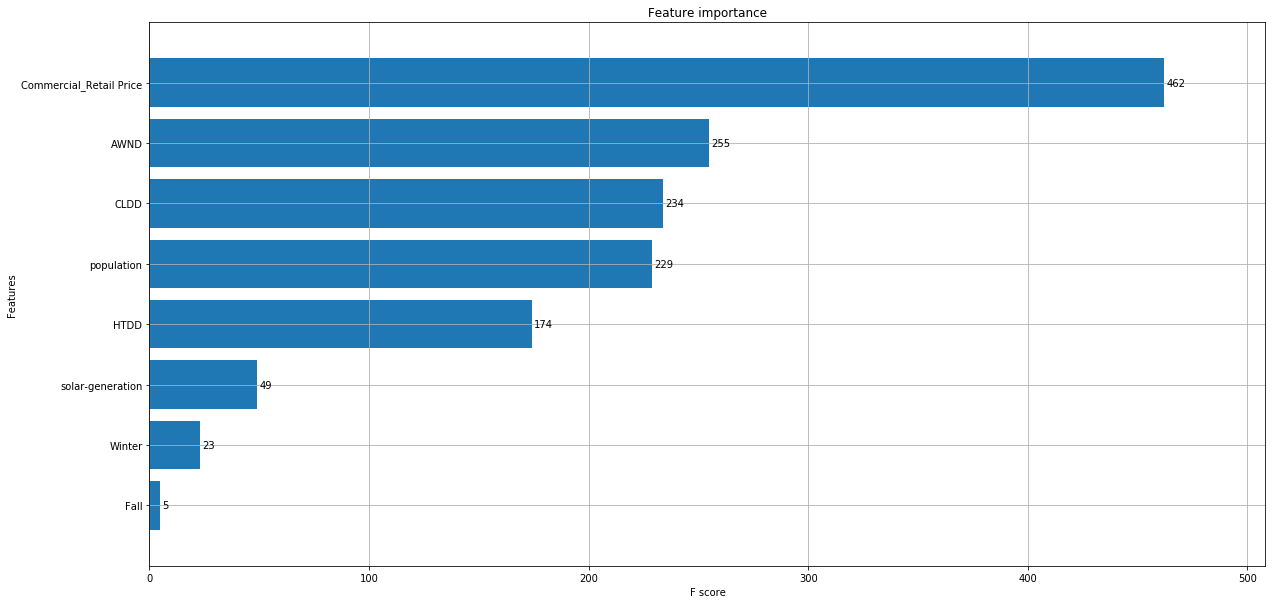

In [27]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

## Visualizations

In [28]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [29]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [30]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


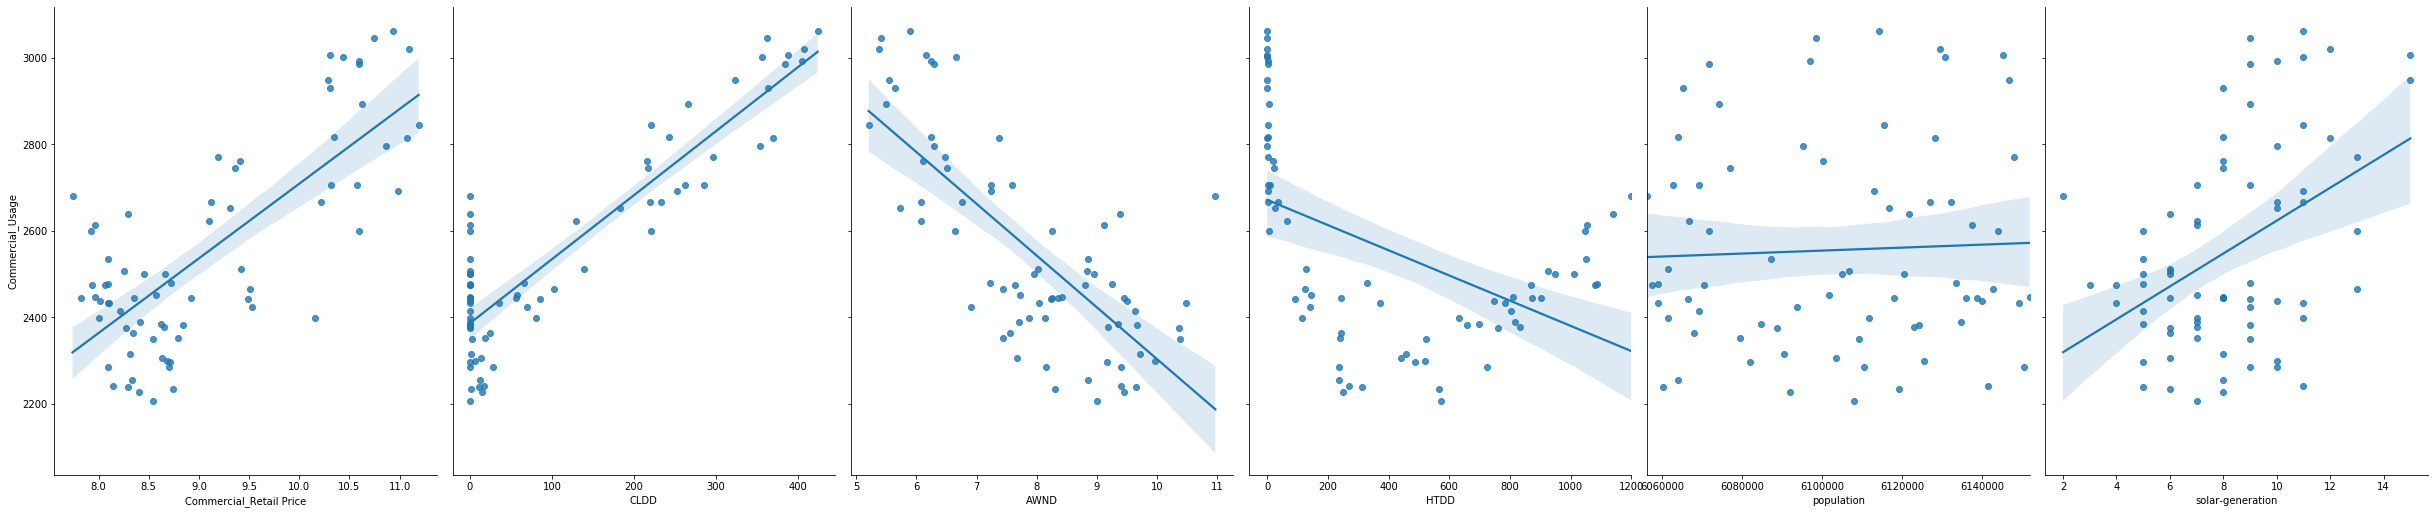

In [50]:
# Correlation Analysis
correlation_analysis(data, commercial_numeric_columns_adj, ['Commercial_Usage'])

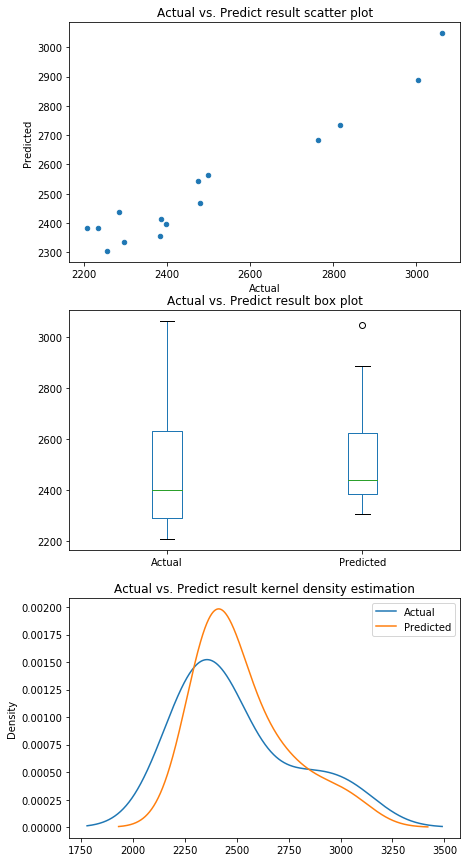

In [32]:
# Visualize Output
visualize_graph(df_pred_c)

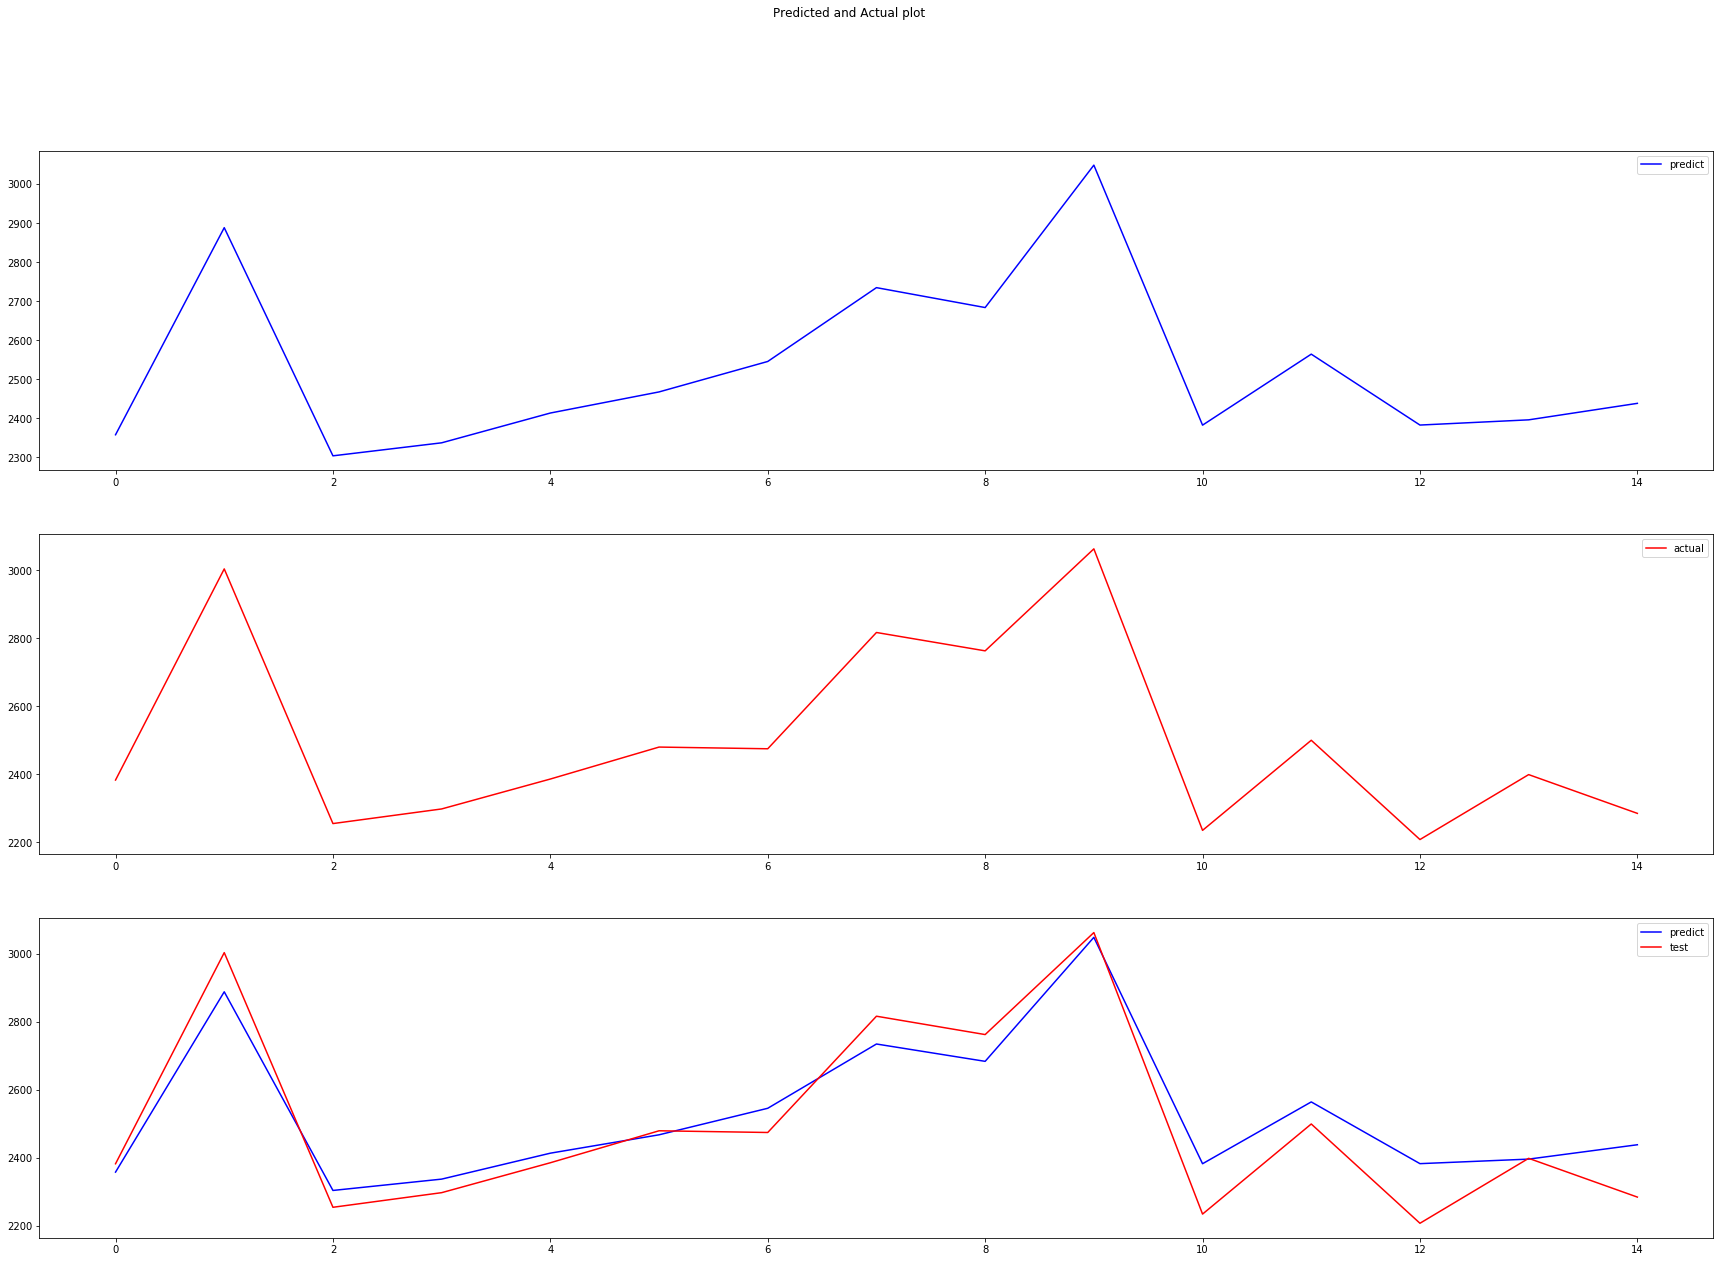

In [33]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

## Industrial Consumption Forecast

In [34]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     48.51
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           8.55e-21
Time:                        14:45:09   Log-Likelihood:                -316.05
No. Observations:                  57   AIC:                             652.1
Df Residuals:                      47   BIC:                             672.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [35]:
df_pred_i

,Actual,Predicted
2523,1083,987.420650
2773,1242,1128.866906
773,1401,1387.883327
1123,1358,1311.441653
1173,1318,1234.755030
2873,1121,1044.819624
573,1392,1390.110990
323,1528,1465.581925
1623,1159,1273.564932
2123,1194,1212.949454


In [36]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 62.79854597894029
Mean Squared Error: 5147.734695108286
Root Mean Squared Error: 71.74771560898846


# Industrial Feature Importance

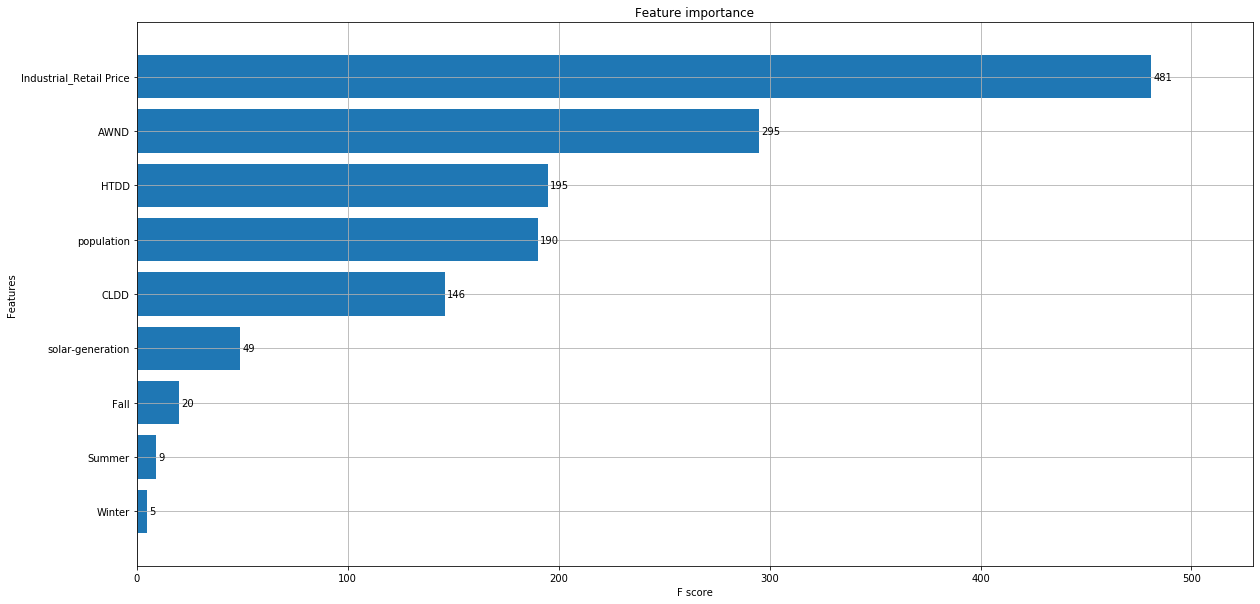

In [37]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


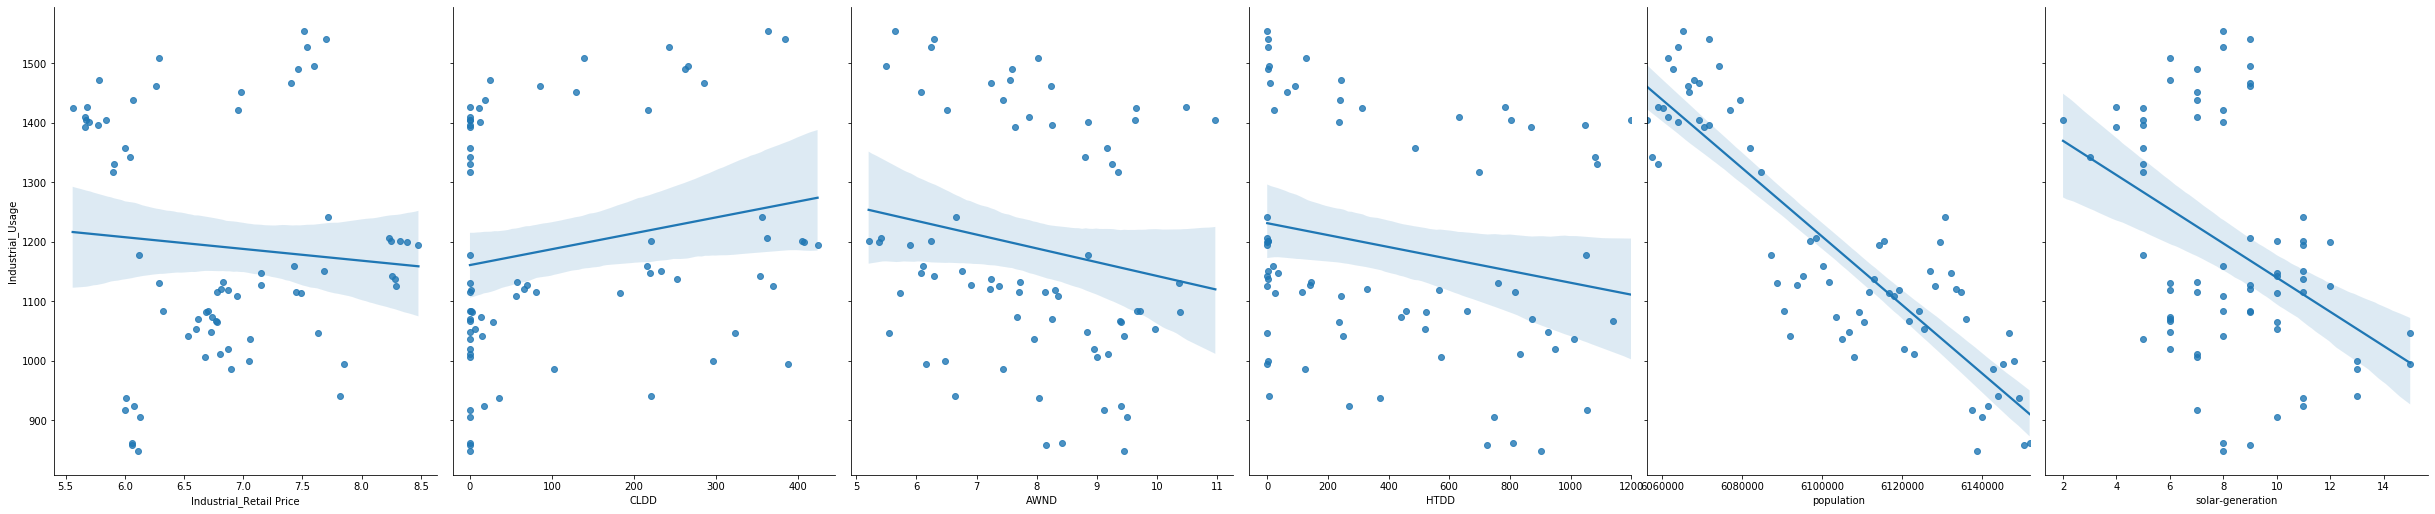

In [49]:
# Correlation Analysis
correlation_analysis(data, industrial_numeric_columns_adj, ['Industrial_Usage'])

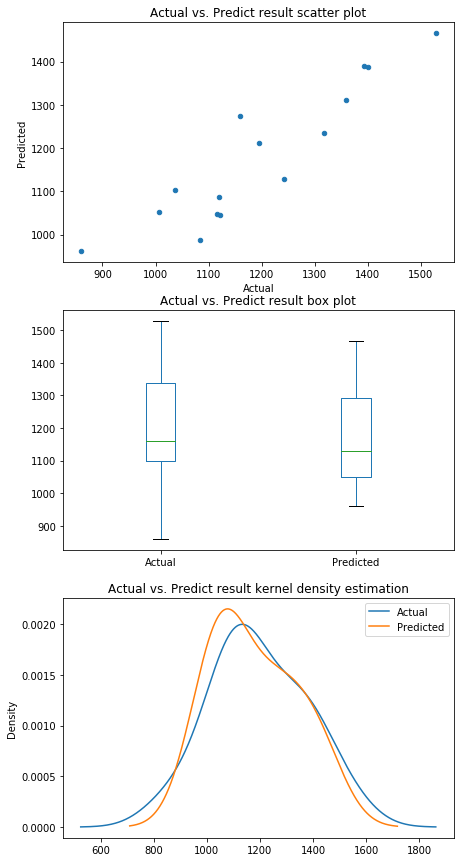

In [39]:
visualize_graph(df_pred_i)

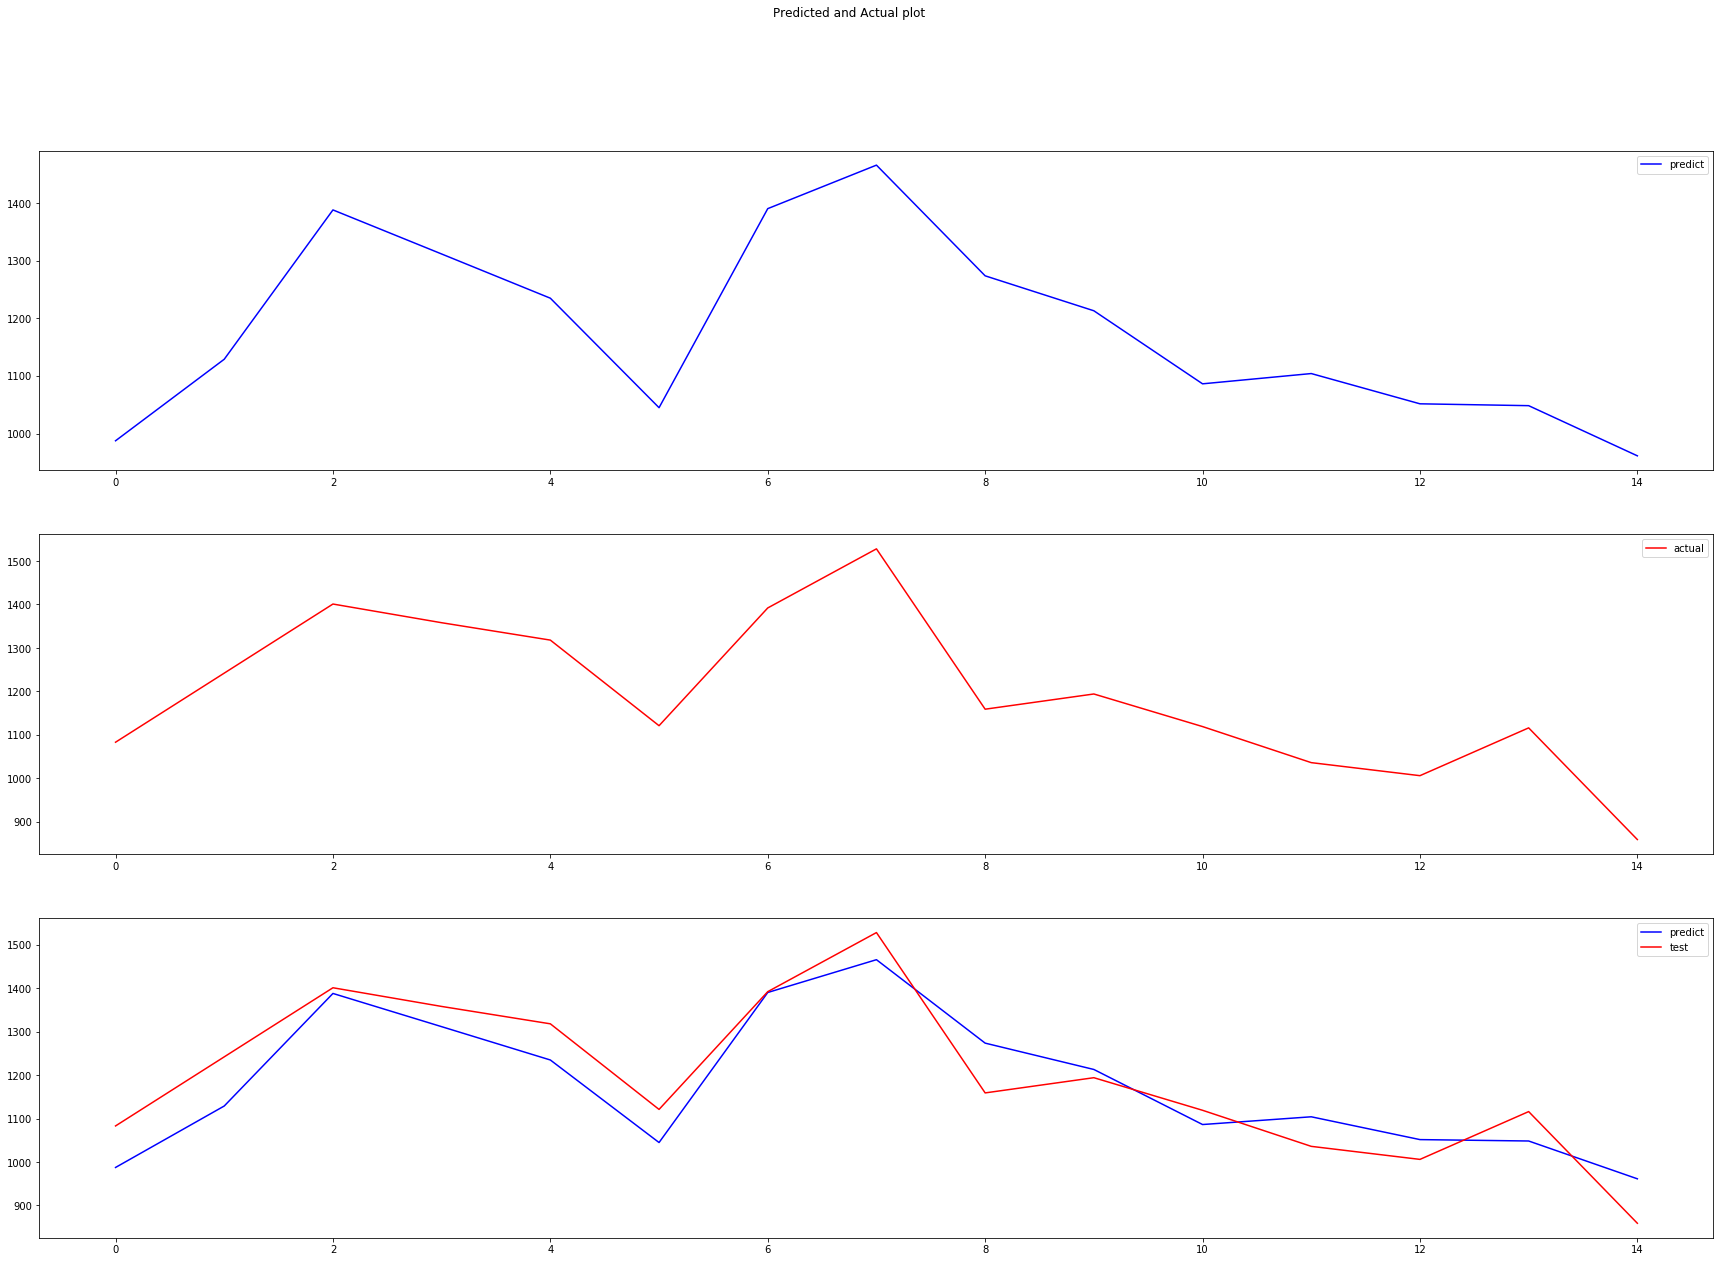

In [40]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

## Residential Consumption Forecast

In [41]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     99.46
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           1.58e-27
Time:                        14:45:19   Log-Likelihood:                -360.04
No. Observations:                  57   AIC:                             740.1
Df Residuals:                      47   BIC:                             760.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [42]:
df_pred_r

,Actual,Predicted
2523,2679.0,2557.366543
2773,3637.0,3492.110969
773,1941.0,2047.210602
1123,2143.0,2182.063641
1173,2798.0,2880.792610
2873,2431.0,2455.743561
573,3329.0,3451.423170
323,3285.0,3068.269020
1623,3019.0,2750.125915
2123,3884.0,3819.158805


In [43]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 147.7776583599763
Mean Squared Error: 27701.4802834782
Root Mean Squared Error: 166.437616792233


## Residential_Feature Importance

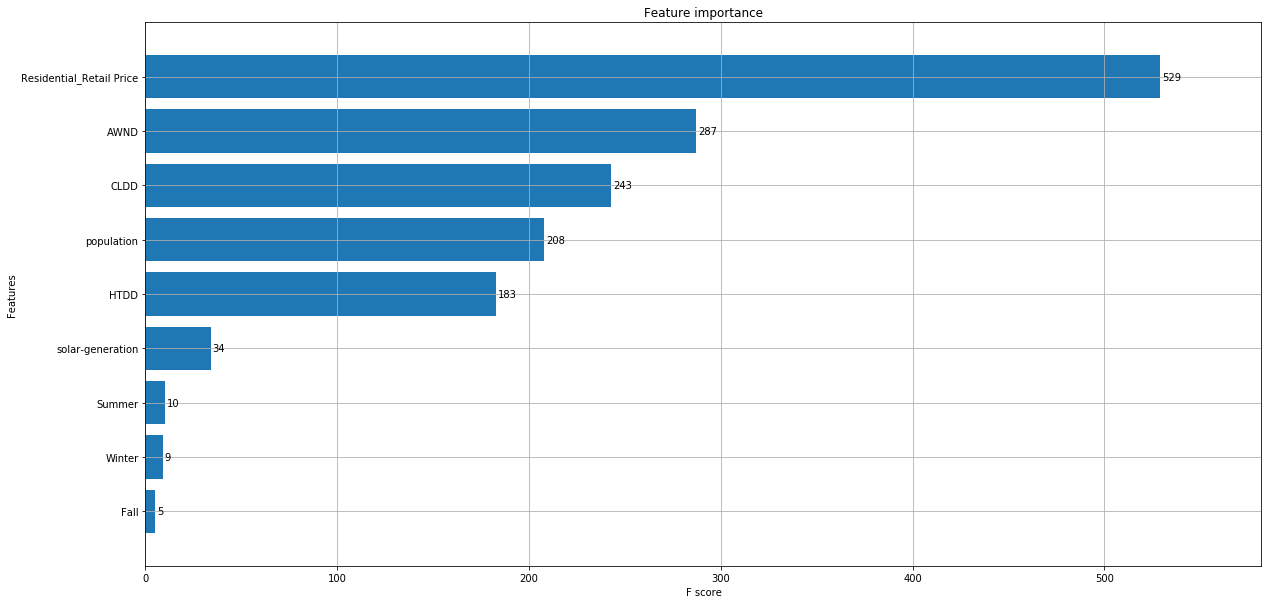

In [44]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


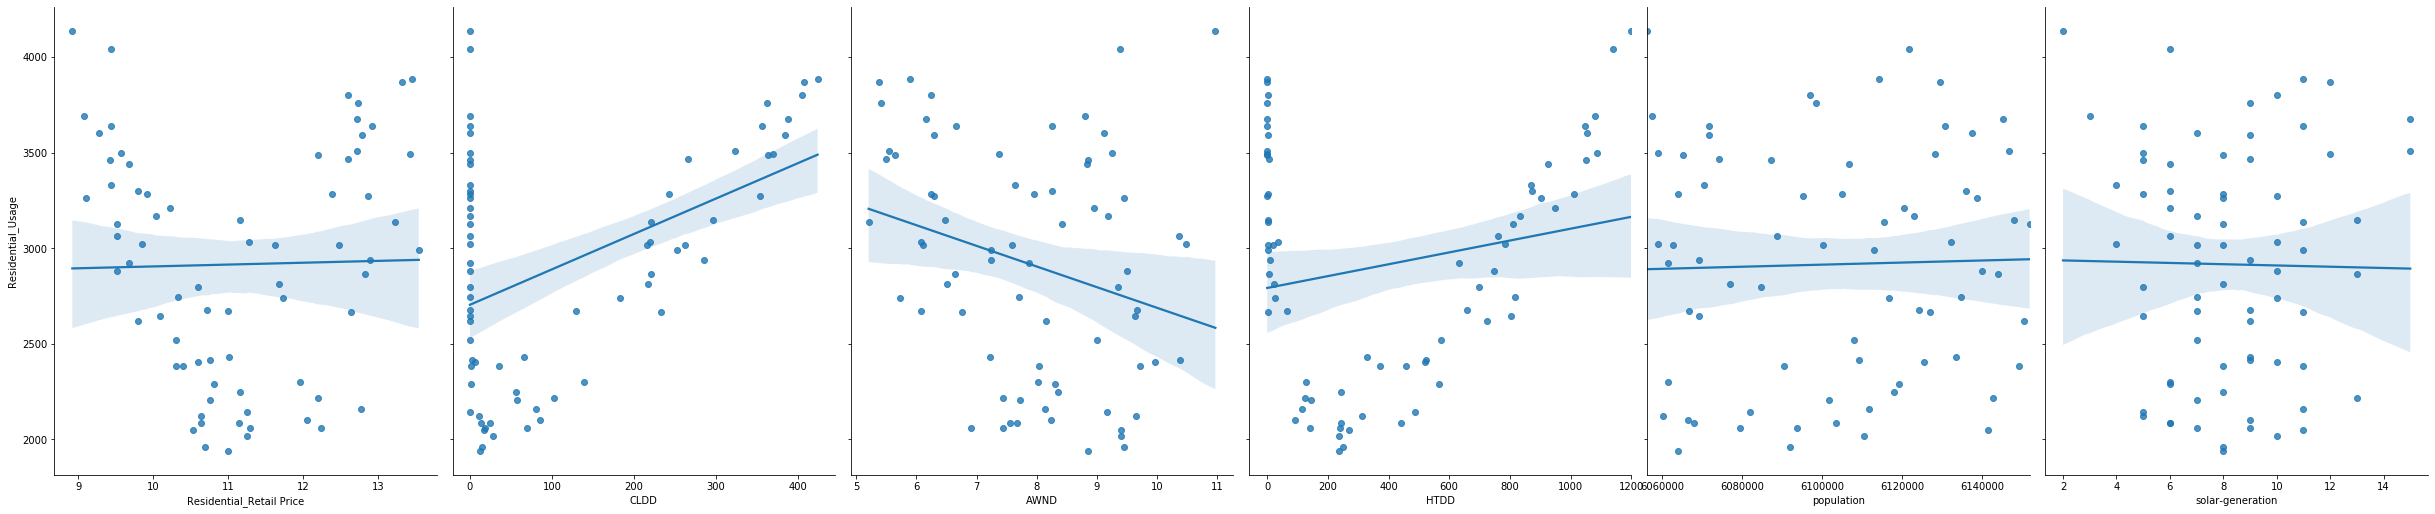

In [48]:
# Correlation Analysis
correlation_analysis(data, residential_numeric_columns_adj, ['Residential_Usage'])

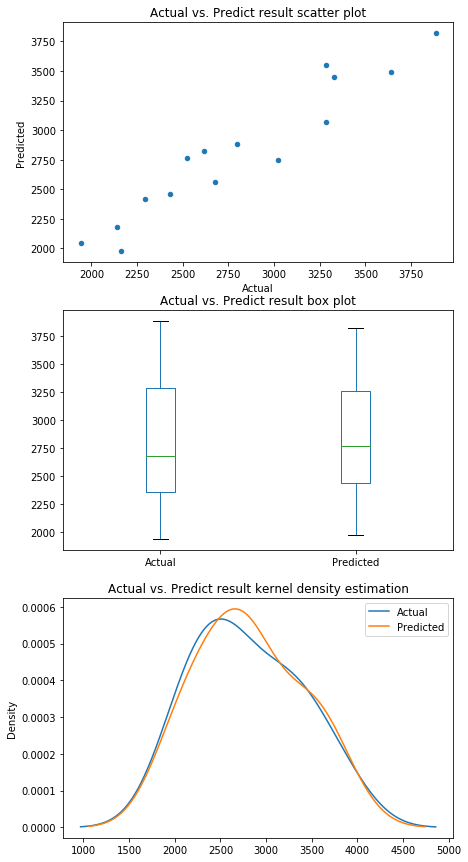

In [46]:
visualize_graph(df_pred_r)

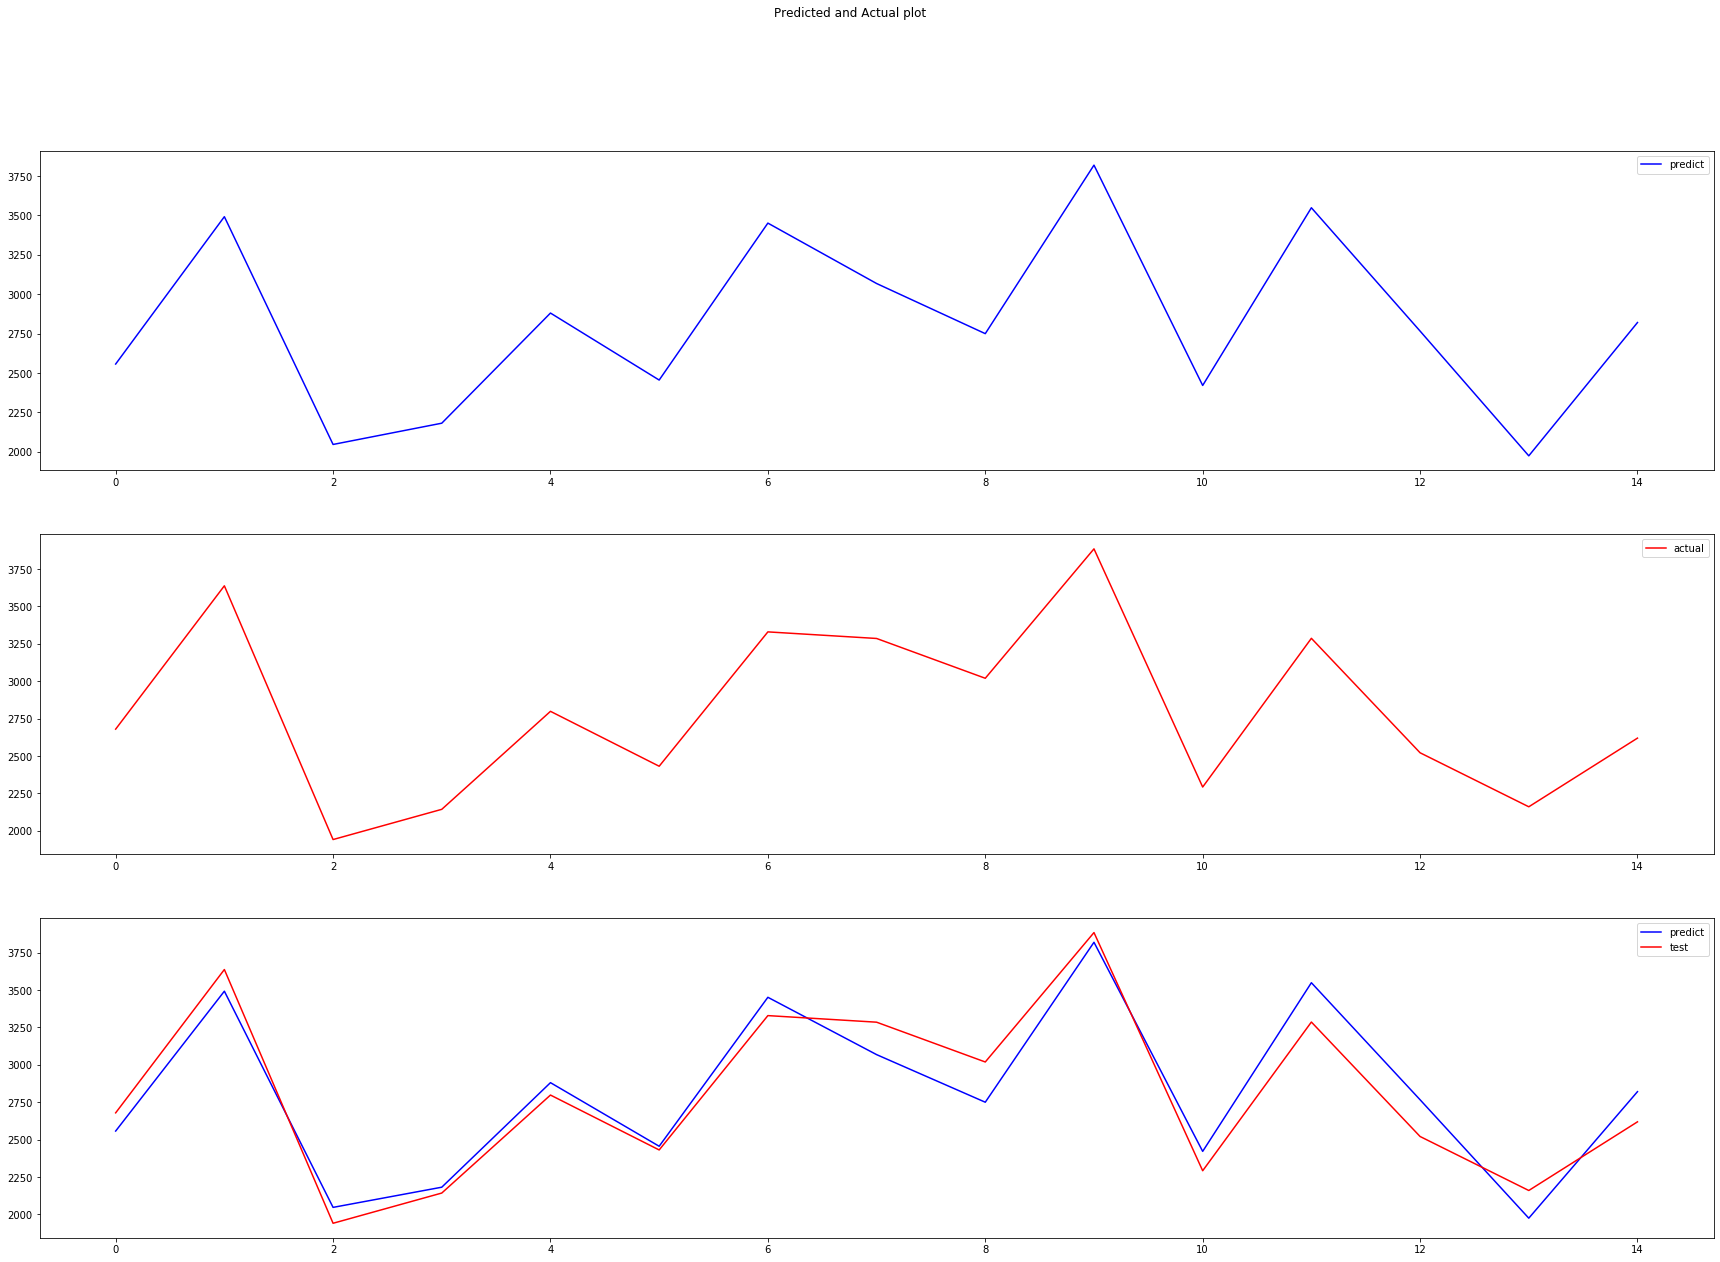

In [47]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)